# Distributional Counterfactual Explanation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read and Process Data

In [2]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()
target_name = 'is_canceled'
target = df[target_name]

In [4]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,14.0,179.0,0,2,0.0,0,0,1,15
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,14.0,179.0,0,2,0.0,0,0,1,15
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,14.0,179.0,0,2,75.0,0,0,1,46
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,179.0,0,2,75.0,0,0,1,46
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,98.0,0,1,1,76


## Model Training

In [5]:
features = [
    # 'hotel', 
    'lead_time', 
    # 'arrival_date_year', 
    # 'arrival_date_month',
    # 'arrival_date_week_number', 
    # 'arrival_date_day_of_month',
    # 'stays_in_weekend_nights', 
    # 'stays_in_week_nights', 
    # 'adults', 
    # 'children',
    # 'babies', 
    # 'meal', 
    # 'country', 
    # 'market_segment', 
    # 'distribution_channel',
    # 'is_repeated_guest', 
    # 'previous_cancellations',
    # 'previous_bookings_not_canceled', 
    # 'reserved_room_type',
    # 'assigned_room_type', 
    'booking_changes', 
    # 'deposit_type', 
    # 'agent',
    # 'company', 
    # 'days_in_waiting_list', 
    # 'customer_type', 
    # 'adr',
    # 'required_car_parking_spaces', 
    # 'total_of_special_requests'
]

df_X = df[features].copy()
df_y = target

In [6]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.6767736077308655

## Counterfactual Explanation

In [21]:
sample_num = 50
delta = 0.25
alpha = 0.10
N=10

indice = (X_test.sample(sample_num)).index

X = X_test.loc[indice].values
y = model(torch.FloatTensor(X))

y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))

y_true = y_test.loc[indice]

In [9]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    X=X, 
    y_target=y_target, 
    lr=1e-1, 
    epsilon=0.5, 
    lambda_val=100, 
    n_proj=N,
    delta=delta)

DEBUG:root:test


In [10]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.5500587432008328

In [11]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=0.10)

(0.17521777664697666, 0.7402555920622533)

In [45]:
from explainers.distances import bootstrap_1d
bootstrap_1d(y, y_target, delta=delta, alpha=alpha)

(0.5306030331008563, 0.660577172611511)

In [13]:
explainer.optimize_without_chance_constraints(max_iter=20)

INFO:root:Optimization (without chance constraints) started
INFO:root:Iter 1: Q = -36.402103424072266, term1 = 0.0008015665225684643, term2 = -36.40290451049805
INFO:root:Iter 2: Q = -37.324913024902344, term1 = 0.0025632972829043865, term2 = -37.327476501464844
INFO:root:Iter 3: Q = -38.01961135864258, term1 = 0.004799350164830685, term2 = -38.024410247802734
INFO:root:Iter 4: Q = -38.51778793334961, term1 = 0.007214750163257122, term2 = -38.525001525878906
INFO:root:Iter 5: Q = -38.95671081542969, term1 = 0.009734423831105232, term2 = -38.96644592285156
INFO:root:Iter 6: Q = -39.675315856933594, term1 = 0.013800102286040783, term2 = -39.689117431640625
INFO:root:Iter 7: Q = -40.04991149902344, term1 = 0.017033696174621582, term2 = -40.06694412231445
INFO:root:Iter 8: Q = -40.5354118347168, term1 = 0.020773304626345634, term2 = -40.55618667602539
INFO:root:Iter 9: Q = -40.8252067565918, term1 = 0.023879937827587128, term2 = -40.84908676147461
INFO:root:Iter 10: Q = -41.044071197509766

In [14]:
X_s = explainer.X.clone()
X_t = explainer.X_prime.clone()

In [15]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

0.30892477509633265

In [65]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha)

(0.0, 2.4230706395311126)

In [71]:
from explainers.distances import bootstrap_sw
bootstrap_sw(X_s, X_t, delta=delta, alpha=alpha, N=N, B=500)

(0.0, 0.4431488957506036)

In [72]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)
# counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy(), columns=df_X.columns)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.best_y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [73]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.102964,0.098996
1,0.430297,0.026841
2,0.507786,0.348373
3,0.678423,0.715933
4,0.185345,0.688129
5,0.158994,0.101253
6,0.498833,0.604614
7,0.450020,0.102583
8,0.235820,0.101577
9,0.397237,0.480115


In [74]:
counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y

In [75]:
factual_X[target_name] = factual_y

In [76]:
counterfactual_X

,lead_time,booking_changes,is_canceled
30843,-13.619563,-0.010087,0.098996
83706,15.217225,3.015860,0.026841
14660,75.405674,0.301373,0.348373
75289,335.968435,-0.006115,0.715933
103311,304.484919,-0.015923,0.688129
85129,-11.912737,0.044638,0.101253
113715,248.404421,-0.014398,0.604614
19185,-12.109116,0.010179,0.102583
31360,-11.580777,0.057419,0.101577
87121,146.595043,0.081353,0.480115


In [77]:
check_column = 'lead_time'
pd.DataFrame({
    'factual': factual_X[check_column].values, 
    'counterfactual': counterfactual_X[check_column].values
    })

,factual,counterfactual
0,168,-13.619563
1,59,15.217225
2,185,75.405674
3,299,335.968435
4,7,304.484919
5,2,-11.912737
6,175,248.404421
7,92,-12.109116
8,152,-11.580777
9,41,146.595043


In [78]:
factual_X[check_column].mean()

110.12

In [79]:
counterfactual_X[check_column].mean()

101.4644218982803

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

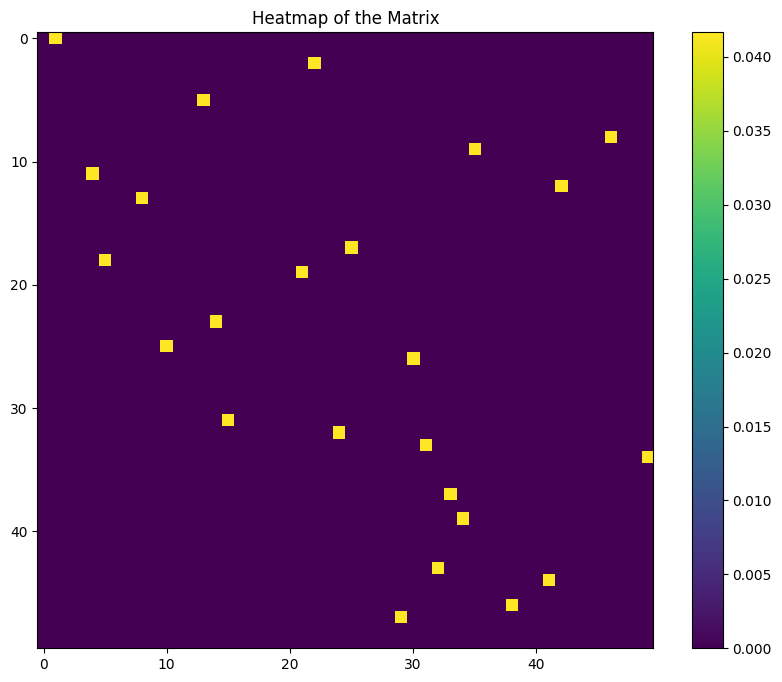

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()
